# Imports, Initialization, and Hyperparameters

First we import required libraries

In [2]:
import pandas as pd
import torch
import numpy as np
import math
import os
import torch_geometric
from scipy.stats import mode
import matplotlib.pyplot as plt
import networkx as nx

Data processing begins with importing relevant gene datasets in the form of Pandas dataframes. We extract the genes present in each dataframe in order to find the overlap between gene and protein datasets.

In [3]:
#Import Rao and Lieberman data
working_dict = os.getcwd()
rao_data = pd.read_csv(working_dict + "/Data/hg38_GM12878_Rao_2014-raw_TADs_with_gene_ids.tsv", sep="\t")
rao_data.drop(['chr','start','end'],axis=1,inplace=True)
lieberman_data = pd.read_csv(working_dict + "/Data/hg38_GM12878_Lieberman_2009-raw_TADs_with_gene_ids.tsv", sep="\t")
lieberman_data.drop(['chr','start','end'],axis=1,inplace=True)

#Process data
def get_genes(data):
    data = data.to_numpy()
    data = data.flatten()
    data = data[~pd.isnull(data)]
    data = list(set(data))
    for i,gene in enumerate(data):
        data[i] = gene.split('.', 1)[0]
    return data

rao_genes = get_genes(rao_data)
lieberman_genes = get_genes(lieberman_data)
len(lieberman_genes), len(rao_genes)

(50295, 56750)

PPI data is imported and filtered to only contain relevant proteins (those present in the gene dataset)

In [4]:
#Import PPI Data and construct protein list
data = pd.read_csv(working_dict + "/Data/HI-union.tsv",sep='\t')
def get_proteins(data,genes):
    output_data = data.drop(data[(data['Protein1'] == data['Protein2']) | (~np.isin(data['Protein1'],genes)) | (~np.isin(data['Protein2'],genes))].index)
    output_data.reset_index(drop=True,inplace=True)
    proteins = set([*output_data.Protein1,*output_data.Protein2])
    proteins = list(proteins)
    return output_data, proteins

Ldata, lieberman_proteins = get_proteins(data,lieberman_genes)
Rdata, rao_proteins = get_proteins(data,rao_genes)

print('Lieberman','Rao')
print(len(lieberman_proteins), len(rao_proteins))
print(Ldata.shape, Rdata.shape)

Lieberman Rao
6944 8312
(40612, 2) (54892, 2)


Quick validation of gene-protein overlap

In [5]:
#Check for overlap between genes and proteins
temp = []
for gene in lieberman_genes:
    if gene in lieberman_proteins:
        temp.append(gene)
lieberman_genes = temp

temp = []
for gene in rao_genes:
    if gene in rao_proteins:
        temp.append(gene)
rao_genes = temp

print(len(lieberman_genes), len(rao_genes))
print(len(lieberman_proteins), len(rao_proteins))

6944 8312
6944 8312


We limit gene clusters to gene-protein overlap

In [6]:
def process(gene,protein_list):
    gene = str(gene)
    gene = gene.split('.', 1)[0]
    if gene in protein_list:
        return gene
    else:
        return np.nan

rao_data = rao_data.applymap(process, protein_list=rao_proteins)
lieberman_data = lieberman_data.applymap(process, protein_list=lieberman_proteins)

rao_data = rao_data.dropna(how='all')
lieberman_data = lieberman_data.dropna(how='all')

In [7]:
#Process gene data into a more usable format
def process_gene_data(data):
    data = data[~pd.isnull(data)]
    supernode = '+'.join(data)
    return supernode

compressed_rao_genes = rao_data.apply(process_gene_data,axis=1)
compressed_lieberman_genes = lieberman_data.apply(process_gene_data,axis=1)

The most important part of the data initialization is the transformation of our data into graph-structured data. We do this by constructing an edge list that can interface with the pytorch_geometric library alongside adjacency and degree matrices.

In [8]:
#Construct Edge List
def construct_edge_list(data,protein_list):
    edge_list = torch.tensor([data['Protein1'].apply(lambda x: protein_list.index(x)).values,data['Protein2'].apply(lambda x: protein_list.index(x)).values],dtype=torch.long)
    edge_list = torch_geometric.utils.to_undirected(edge_list)
    return edge_list

lieberman_edge_list = construct_edge_list(Ldata,lieberman_proteins)
rao_edge_list = construct_edge_list(Rdata,rao_proteins)

#Contruct Adjacency Matrix from Edge List
def construct_adjacency_matrix(edge_list,protein_list):
    A = torch.zeros(len(protein_list),len(protein_list))
    for i in range(edge_list.shape[1]):
        A[edge_list[0,i],edge_list[1,i]] = 1
        A[edge_list[1,i],edge_list[0,i]] = 1
    return A
lieberman_A = construct_adjacency_matrix(lieberman_edge_list,lieberman_proteins)
rao_A = construct_adjacency_matrix(rao_edge_list,rao_proteins)

#Construct Degree Matrix from Adjacency Matrix
def construct_degree_matrix(A):
    D = torch.zeros(len(A),len(A))
    for i in range(len(A)):
        D[i,i] = A[i].sum()
    return D
lieberman_D = construct_degree_matrix(lieberman_A)
rao_D = construct_degree_matrix(rao_A)

#Construct Laplacian Matrix from Degree Matrix and Adjacency Matrix
lieberman_L = lieberman_D - lieberman_A
rao_L = rao_D - rao_A

#Define Max Degree
lieberman_max = lieberman_D.max().item()
rao_max = rao_D.max().item()
print(lieberman_max,rao_max)

/tmp/ipykernel_1693691/2538538093.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  edge_list = torch.tensor([data['Protein1'].apply(lambda x: protein_list.index(x)).values,data['Protein2'].apply(lambda x: protein_list.index(x)).values],dtype=torch.long)


517.0 604.0


In [9]:
##Hyperparameters



#K: Maximum hop distance (K = 2)
K = 2

#Gamma: Hop discount factor (γ = 0.01)
gamma = 0.01

#Eta: Node degree threshold (η = 15)
eta = 15

#Phi: Compression ratio (φ = 0.2)
rao_phi = 1 - (rao_data.shape[0] / len(rao_genes)) #Rao
lieberman_phi = 1 - (lieberman_data.shape[0] / len(lieberman_genes)) #Lieberman
print('Rao',rao_phi)
print('Lieberman',lieberman_phi)

#m: Hidden layer size (m = log2(max_degree))
m = int(math.log2(lieberman_max)) + 1 #It is the same max for both datasets

#p: Embedding layer size (p = 2m)
p = 2*m

Rao 0.6856352261790183
Lieberman 0.838565668202765


# Exploratory Analysis

We begin by transforming our graphs into networkx format

In [16]:
#Transform graphs into networkx format
lieberman_G = nx.from_numpy_array(lieberman_A.numpy())
rao_G = nx.from_numpy_array(rao_A.numpy())

Visualize graphs by community

In [23]:
def visualize_graph(G):
    communities = nx.community.greedy_modularity_communities(G)

    # Compute positions for the node clusters as if they were themselves nodes in a
    # supergraph using a larger scale factor
    supergraph = nx.cycle_graph(len(communities))
    superpos = nx.spring_layout(G, scale=50, seed=429)

    # Use the "supernode" positions as the center of each node cluster
    centers = list(superpos.values())
    pos = {}
    for center, comm in zip(centers, communities):
        pos.update(nx.spring_layout(nx.subgraph(G, comm), center=center, seed=1430))

    # Nodes colored by cluster
    for nodes in communities:
        nx.draw_networkx_nodes(G, pos=pos, nodelist=nodes,node_size=5)
    nx.draw_networkx_edges(G, pos=pos)

    plt.tight_layout()
    plt.show()

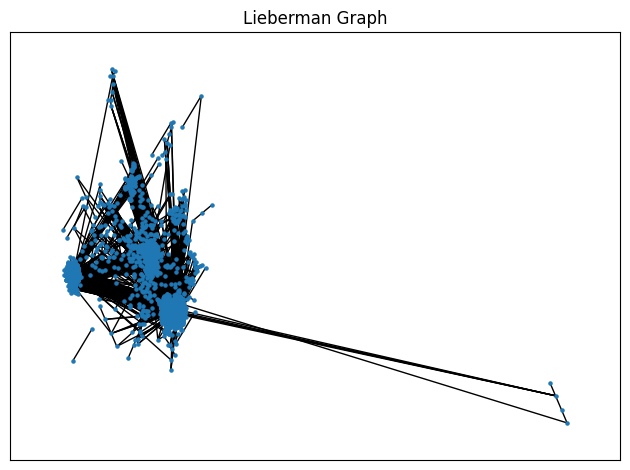

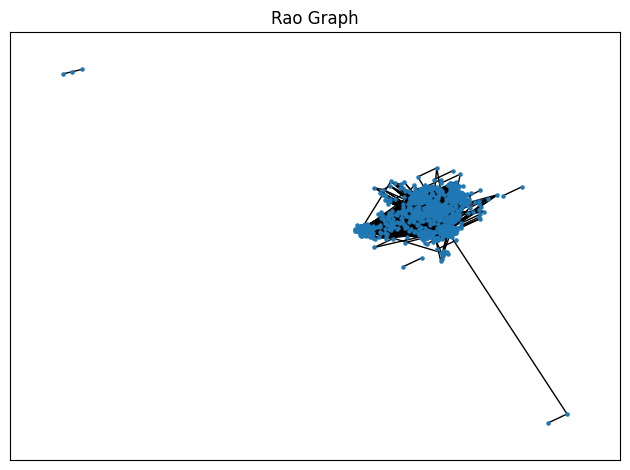

In [25]:
plt.figure(1)
plt.title('Lieberman Graph')
visualize_graph(lieberman_G)

plt.figure(2)
plt.title('Rao Graph')
visualize_graph(rao_G)

Next we analyze the connectivity of our graphs using node degrees

In [49]:
def visualize_degree(G,ax,title):

    degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
    ax.bar(*np.unique(degree_sequence, return_counts=True),log=True)
    ax.set_title(title)
    ax.set_xlabel("Degree")
    ax.set_ylabel("# of Nodes")
    ax.xlim = (0, max(degree_sequence))
    ax.ylim = (0, 750)

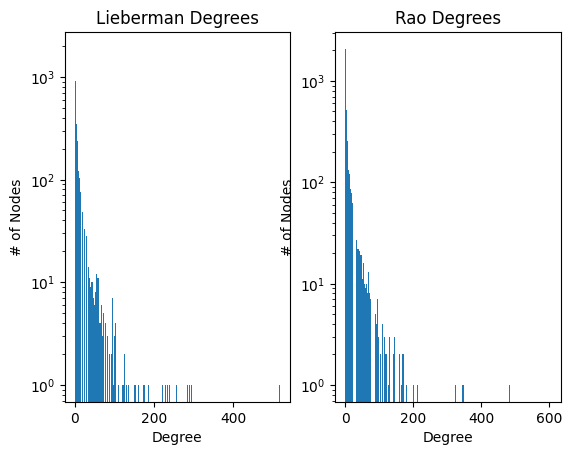

In [50]:
fig, ax = plt.subplots(1, 2)
visualize_degree(lieberman_G,ax[0],"Lieberman Degrees")

visualize_degree(rao_G,ax[1],"Rao Degrees")

# Model Architecture

## Feature Extractors

We will be comparing two graph feature extractors and testing their concatenated outputs
* Degree Proximity (MERGE/REGAL)
* Random Walks (Node2Vec)
* Concatenated Features

### Degree Proximity

In [24]:
def extract_features(protein_list,edge_list,D):
    features = torch.zeros(len(protein_list),m,dtype=torch.float32)
    k = 1

    while k <= K:
        for protein in range(len(protein_list)):
            #Get k-hop neighbors of protein
            neighbors = torch_geometric.utils.k_hop_subgraph(protein,k,edge_list)[0]

            #Get temporary features using neighbor degrees
            temporary_features = torch.zeros([m])
            for neighbor in neighbors:
                idx = int(math.log2(D[neighbor,neighbor].item()))
                temporary_features[idx] += 1

            #Apply hop discount factor and add to features
            temporary_features = pow(gamma,k-1)*temporary_features
            features[protein] += temporary_features
        k += 1
    return features

lieberman_merge_features = extract_features(lieberman_proteins,lieberman_edge_list,lieberman_D)
rao_merge_features = extract_features(rao_proteins,rao_edge_list,rao_D)
print(lieberman_merge_features.shape,rao_merge_features.shape)

torch.Size([6944, 10]) torch.Size([8312, 10])


## Embedding Models

We will be comparing many graph encoders, classified into two groups
* Unsupervised Learners (GCNs,GATs,GraphSAGE)
* Contrastive Learners (Deep Graph Infomax)

In [17]:
import torch.nn as nn
import torch.nn.functional as nnF
from torch_geometric.nn import GCNConv, GATConv, SAGEConv

### Encoders

#### GCN

In [87]:
class OneLayerGCN(torch.nn.Module):
    def __init__(self, in_features):
        super(OneLayerGCN, self).__init__()
        
        #GCN Layers
        self.conv1 = GCNConv(in_features, 128)
        self.act1 = nn.PReLU()
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.act1(x)
        return x

In [88]:
class ThreeLayerGCN(torch.nn.Module):
    def __init__(self, in_features):
        super(ThreeLayerGCN, self).__init__()
        
        #GCN Layers
        self.conv1 = GCNConv(in_features, 128)
        self.conv2 = GCNConv(128, 128)
        self.conv3 = GCNConv(128, 128)
        self.act1 = nn.PReLU()
        self.act2 = nn.PReLU()
        self.act3 = nn.PReLU()
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.act1(x)
        x = self.conv2(x, edge_index)
        x = self.act2(x)
        x = self.conv3(x, edge_index)
        x = self.act3(x)
        return x

In [93]:
class TenLayerGCN(torch.nn.Module):
    def __init__(self, in_features):
        super(TenLayerGCN, self).__init__()
        
        #GCN Layers
        self.conv1 = GCNConv(in_features, 128)
        self.conv2 = GCNConv(128, 128)
        self.conv3 = GCNConv(128, 128)
        self.conv4 = GCNConv(128, 128)
        self.conv5 = GCNConv(128, 128)
        self.conv6 = GCNConv(128, 128)
        self.conv7 = GCNConv(128, 128)
        self.conv8 = GCNConv(128, 128)
        self.conv9 = GCNConv(128, 128)
        self.conv10 = GCNConv(128, 128)
        
        self.act1 = nn.PReLU()
        self.act2 = nn.PReLU()
        self.act3 = nn.PReLU()
        self.act4 = nn.PReLU()
        self.act5 = nn.PReLU()
        self.act6 = nn.PReLU()
        self.act7 = nn.PReLU()
        self.act8 = nn.PReLU()
        self.act9 = nn.PReLU()
        self.act10 = nn.PReLU()
        
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.act1(x)
        x = self.conv2(x, edge_index)
        x = self.act2(x)
        x = self.conv3(x, edge_index)
        x = self.act3(x)
        x = self.conv4(x, edge_index)
        x = self.act4(x)
        x = self.conv5(x, edge_index)
        x = self.act5(x)
        x = self.conv6(x, edge_index)
        x = self.act6(x)
        x = self.conv7(x, edge_index)
        x = self.act7(x)
        x = self.conv8(x, edge_index)
        x = self.act8(x)
        x = self.conv9(x, edge_index)
        x = self.act9(x)
        x = self.conv10(x, edge_index)
        x = self.act10(x)
        return x

#### GraphSAGE

In [105]:
class OneLayerSAGE(torch.nn.Module):
    def __init__(self, in_features):
        super(OneLayerSAGE, self).__init__()
        
        #GCN Layers
        self.conv1 = SAGEConv(in_features, 128)
        self.act1 = nn.PReLU()
        
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.act1(x)
        return x

In [107]:
class ThreeLayerSAGE(torch.nn.Module):
    def __init__(self, in_features):
        super(ThreeLayerSAGE, self).__init__()
        
        #GCN Layers
        self.conv1 = SAGEConv(in_features, 128)
        self.conv2 = SAGEConv(128, 128)
        self.conv3 = SAGEConv(128, 128)
        self.act1 = nn.PReLU()
        self.act2 = nn.PReLU()
        self.act3 = nn.PReLU()
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.act1(x)
        x = self.conv2(x, edge_index)
        x = self.act2(x)
        x = self.conv3(x, edge_index)
        x = self.act3(x)
        return x

In [108]:
class TenLayerSAGE(torch.nn.Module):
    def __init__(self, in_features):
        super(TenLayerSAGE, self).__init__()
        
        #GCN Layers
        self.conv1 = SAGEConv(in_features, 128)
        self.conv2 = SAGEConv(128, 128)
        self.conv3 = SAGEConv(128, 128)
        self.conv4 = SAGEConv(128, 128)
        self.conv5 = SAGEConv(128, 128)
        self.conv6 = SAGEConv(128, 128)
        self.conv7 = SAGEConv(128, 128)
        self.conv8 = SAGEConv(128, 128)
        self.conv9 = SAGEConv(128, 128)
        self.conv10 = SAGEConv(128, 128)
        
        self.act1 = nn.PReLU()
        self.act2 = nn.PReLU()
        self.act3 = nn.PReLU()
        self.act4 = nn.PReLU()
        self.act5 = nn.PReLU()
        self.act6 = nn.PReLU()
        self.act7 = nn.PReLU()
        self.act8 = nn.PReLU()
        self.act9 = nn.PReLU()
        self.act10 = nn.PReLU()
        
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.act1(x)
        x = self.conv2(x, edge_index)
        x = self.act2(x)
        x = self.conv3(x, edge_index)
        x = self.act3(x)
        x = self.conv4(x, edge_index)
        x = self.act4(x)
        x = self.conv5(x, edge_index)
        x = self.act5(x)
        x = self.conv6(x, edge_index)
        x = self.act6(x)
        x = self.conv7(x, edge_index)
        x = self.act7(x)
        x = self.conv8(x, edge_index)
        x = self.act8(x)
        x = self.conv9(x, edge_index)
        x = self.act9(x)
        x = self.conv10(x, edge_index)
        x = self.act10(x)
        return x

#### GAT

In [126]:
class OneLayerGAT(torch.nn.Module):
    def __init__(self, in_features):
        super(OneLayerGAT, self).__init__()
        
        #GCN Layers
        self.conv1 = GATConv(in_features, 128)
        self.act1 = nn.PReLU()
        
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.act1(x)
        return x

In [130]:
class ThreeLayerGAT(torch.nn.Module):
    def __init__(self, in_features):
        super(ThreeLayerGAT, self).__init__()
        
        #GCN Layers
        self.conv1 = GATConv(in_features, 128)
        self.conv2 = GATConv(128, 128)
        self.conv3 = GATConv(128, 128)
        self.act1 = nn.PReLU()
        self.act2 = nn.PReLU()
        self.act3 = nn.PReLU()
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.act1(x)
        x = self.conv2(x, edge_index)
        x = self.act2(x)
        x = self.conv3(x, edge_index)
        x = self.act3(x)
        return x

In [138]:
class TenLayerGAT(torch.nn.Module):
    def __init__(self, in_features):
        super(TenLayerGAT, self).__init__()
        
        #GCN Layers
        self.conv1 = GATConv(in_features, 128)
        self.conv2 = GATConv(128, 128)
        self.conv3 = GATConv(128, 128)
        self.conv4 = GATConv(128, 128)
        self.conv5 = GATConv(128, 128)
        self.conv6 = GATConv(128, 128)
        self.conv7 = GATConv(128, 128)
        self.conv8 = GATConv(128, 128)
        self.conv9 = GATConv(128, 128)
        self.conv10 = GATConv(128, 128)
        
        self.act1 = nn.PReLU()
        self.act2 = nn.PReLU()
        self.act3 = nn.PReLU()
        self.act4 = nn.PReLU()
        self.act5 = nn.PReLU()
        self.act6 = nn.PReLU()
        self.act7 = nn.PReLU()
        self.act8 = nn.PReLU()
        self.act9 = nn.PReLU()
        self.act10 = nn.PReLU()
        
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.act1(x)
        x = self.conv2(x, edge_index)
        x = self.act2(x)
        x = self.conv3(x, edge_index)
        x = self.act3(x)
        x = self.conv4(x, edge_index)
        x = self.act4(x)
        x = self.conv5(x, edge_index)
        x = self.act5(x)
        x = self.conv6(x, edge_index)
        x = self.act6(x)
        x = self.conv7(x, edge_index)
        x = self.act7(x)
        x = self.conv8(x, edge_index)
        x = self.act8(x)
        x = self.conv9(x, edge_index)
        x = self.act9(x)
        x = self.conv10(x, edge_index)
        x = self.act10(x)
        return x

#### Combined

In [154]:
class ThreeLayerCombined(torch.nn.Module):
    def __init__(self, in_features):
        super(ThreeLayerCombined, self).__init__()
        
        #GCN Layers
        self.conv1 = GCNConv(in_features, 128)
        self.conv2 = SAGEConv(128, 128)
        self.conv3 = GATConv(128, 128)
        self.act1 = nn.PReLU()
        self.act2 = nn.PReLU()
        self.act3 = nn.PReLU()
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.act1(x)
        x = self.conv2(x, edge_index)
        x = self.act2(x)
        x = self.conv3(x, edge_index)
        x = self.act3(x)
        return x

In [160]:
class SixLayerCombined(torch.nn.Module):
    def __init__(self, in_features):
        super(SixLayerCombined, self).__init__()
        
        #GCN Layers
        self.conv1 = GCNConv(in_features, 128)
        self.conv2 = SAGEConv(128, 128)
        self.conv3 = GATConv(128, 128)
        self.conv4 = GCNConv(128, 128)
        self.conv5 = SAGEConv(128, 128)
        self.conv6 = GATConv(128, 128)
        self.act1 = nn.PReLU()
        self.act2 = nn.PReLU()
        self.act3 = nn.PReLU()
        self.act4 = nn.PReLU()
        self.act5 = nn.PReLU()
        self.act6 = nn.PReLU()
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.act1(x)
        x = self.conv2(x, edge_index)
        x = self.act2(x)
        x = self.conv3(x, edge_index)
        x = self.act3(x)
        x = self.conv4(x, edge_index)
        x = self.act4(x)
        x = self.conv5(x, edge_index)
        x = self.act5(x)
        x = self.conv6(x, edge_index)
        x = self.act6(x)
        return x

In [164]:
class NineLayerCombined(torch.nn.Module):
    def __init__(self, in_features):
        super(NineLayerCombined, self).__init__()
        
        #GCN Layers
        self.conv1 = GCNConv(in_features, 128)
        self.conv2 = SAGEConv(128, 128)
        self.conv3 = GATConv(128, 128)
        self.conv4 = GCNConv(128, 128)
        self.conv5 = SAGEConv(128, 128)
        self.conv6 = GATConv(128, 128)
        self.conv7 = GCNConv(128, 128)
        self.conv8 = SAGEConv(128, 128)
        self.conv9 = GATConv(128, 128)
        self.act1 = nn.PReLU()
        self.act2 = nn.PReLU()
        self.act3 = nn.PReLU()
        self.act4 = nn.PReLU()
        self.act5 = nn.PReLU()
        self.act6 = nn.PReLU()
        self.act7 = nn.PReLU()
        self.act8 = nn.PReLU()
        self.act9 = nn.PReLU()
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.act1(x)
        x = self.conv2(x, edge_index)
        x = self.act2(x)
        x = self.conv3(x, edge_index)
        x = self.act3(x)
        x = self.conv4(x, edge_index)
        x = self.act4(x)
        x = self.conv5(x, edge_index)
        x = self.act5(x)
        x = self.conv6(x, edge_index)
        x = self.act6(x)
        x = self.conv7(x, edge_index)
        x = self.act7(x)
        x = self.conv8(x, edge_index)
        x = self.act8(x)
        x = self.conv9(x, edge_index)
        x = self.act9(x)
        return x

In [174]:
class TwelveLayerCombined(torch.nn.Module):
    def __init__(self, in_features):
        super(TwelveLayerCombined, self).__init__()
        
        #GCN Layers
        self.conv1 = GCNConv(in_features, 128)
        self.conv2 = SAGEConv(128, 128)
        self.conv3 = GATConv(128, 128)
        self.conv4 = GCNConv(128, 128)
        self.conv5 = SAGEConv(128, 128)
        self.conv6 = GATConv(128, 128)
        self.conv7 = GCNConv(128, 128)
        self.conv8 = SAGEConv(128, 128)
        self.conv9 = GATConv(128, 128)
        self.conv10 = GCNConv(128, 128)
        self.conv11 = SAGEConv(128, 128)
        self.conv12 = GATConv(128, 128)
        self.act1 = nn.PReLU()
        self.act2 = nn.PReLU()
        self.act3 = nn.PReLU()
        self.act4 = nn.PReLU()
        self.act5 = nn.PReLU()
        self.act6 = nn.PReLU()
        self.act7 = nn.PReLU()
        self.act8 = nn.PReLU()
        self.act9 = nn.PReLU()
        self.act10 = nn.PReLU()
        self.act11 = nn.PReLU()
        self.act12 = nn.PReLU()
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.act1(x)
        x = self.conv2(x, edge_index)
        x = self.act2(x)
        x = self.conv3(x, edge_index)
        x = self.act3(x)
        x = self.conv4(x, edge_index)
        x = self.act4(x)
        x = self.conv5(x, edge_index)
        x = self.act5(x)
        x = self.conv6(x, edge_index)
        x = self.act6(x)
        x = self.conv7(x, edge_index)
        x = self.act7(x)
        x = self.conv8(x, edge_index)
        x = self.act8(x)
        x = self.conv9(x, edge_index)
        x = self.act9(x)
        x = self.conv10(x, edge_index)
        x = self.act10(x)
        x = self.conv11(x, edge_index)
        x = self.act11(x)
        x = self.conv12(x, edge_index)
        x = self.act12(x)
        return x

### Contrastive Learning Helpers

In [18]:
def corruption(x, edge_index):
    return x[torch.randperm(x.size(0))], edge_index

## Clustering Models

We will be comparing 3 graph clustering models
* DBSCAN
* Louvain's Algorithm
* Newman's Eigenvector Algorithm

In [27]:
from sknetwork.clustering import Louvain, get_modularity
from sknetwork.linalg import normalize
from sknetwork.utils import get_membership

### DBSCAN

### Louvain

### Newman Eigenvector

# Model Construction

## Architecture & Functions

In [115]:
from torch_geometric.nn import DeepGraphInfomax, Node2Vec
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [20]:
class FeatureEmbeddingModel(torch.nn.Module):
    def __init__(self, edge_list, extractor, encoder, clusterer):
        super(FeatureEmbeddingModel, self).__init__()
        
        #Initialize desired feature extractor
        if extractor == 0:
            self.featureExtractor = "MERGE"
        else:
            self.featureExtractor = Node2Vec(edge_list, embedding_dim=128, walk_length=20, context_size=10)
            if extractor == 2:
                self.concatFlag = True
        
        #Initialize desired encoder
        self.encoder = encoder
        
        #Initialize desired clusterer
        self.clusterer = clusterer
    
    def forward(self, input_features, edge_list):
        if self.featureExtractor == "MERGE":
            x = input_features
        else:
            x = self.featureExtractor(edge_list).embedding.weight.clone().detach()
            if self.concatFlag:
                x = torch.cat((x,input_features),1)
        return self.encoder.forward(x,edge_list)
    
    def loss(self, x, edge_list):
        return (1 - silhouette_score(x, self.clusterer.fit_predict(x)))**2

In [12]:
def train_FEM(FEM_model, optimizer, features, edge_list):
    features, edge_list = features.to(device), edge_list.to(device)
    
    FEM_model.train()
    optimizer.zero_grad()
    
    embeddings = FEM_model(features, edge_list)
    loss = FEM_model.loss(embeddings, edge_list)
    
    loss.backward()
    optimizer.step()
    return loss

In [45]:
class DGIFeatureEmbeddingModel(torch.nn.Module):
    def __init__(self, edge_list, extractor, encoder):
        super(DGIFeatureEmbeddingModel, self).__init__()
        
        #Initialize desired feature extractor
        self.concatFlag = False
        if extractor == 0:
            self.featureExtractor = "MERGE"
        else:
            self.featureExtractor = Node2Vec(edge_list, embedding_dim=128, walk_length=20, context_size=10)
            if extractor == 2:
                self.concatFlag = True
        
        #Initialize desired encoder
        self.DGI = DeepGraphInfomax(
            hidden_channels=128, 
            encoder=encoder, 
            summary=lambda z, *args, **kwargs: torch.sigmoid(z.mean(dim=0)),
            corruption=corruption
            )
    
    def forward(self, input_features, edge_list):
        if self.featureExtractor == "MERGE":
            x = input_features
        else:
            x = self.featureExtractor(edge_list)
            if self.concatFlag:
                x = torch.cat((x,input_features),1)
        return x
    
    def loss(self, pos_z, neg_z, summary):
        return self.DGI.loss(pos_z, neg_z, summary)

In [46]:
def train_DGIFEM(DGI_model, optimizer, features, edge_list):
    features, edge_list = features.to(device), edge_list.to(device)
    
    DGI_model.train()
    optimizer.zero_grad()
    
    embeddings = DGI_model.forward(features, edge_list)
    
    pos_z, neg_z, summary = DGI_model.DGI(embeddings, edge_list)
    loss = DGI_model.loss(pos_z, neg_z, summary)
    
    loss.backward()
    optimizer.step()
    return loss

## Training

In [179]:
# testmodel1 = DGIFeatureEmbeddingModel(lieberman_edge_list, 0, TwelveLayerCombined(in_features=10)).to(device)
testmodel2 = DGIFeatureEmbeddingModel(lieberman_edge_list, 1, OneLayerGCN(in_features=128)).to(device)
# testmodel3 = DGIFeatureEmbeddingModel(lieberman_edge_list, 2, GCN(in_features=138)).to(device)

loss1list = []
loss2list = []

for epoch in range(1,301,1):
    # loss1 = train_DGIFEM(testmodel1, torch.optim.Adam(testmodel1.parameters(), lr=0.0001), lieberman_merge_features, lieberman_edge_list)
    loss2 = train_DGIFEM(testmodel2, torch.optim.Adam(testmodel2.parameters(), lr=0.0001), lieberman_merge_features, lieberman_edge_list)
    # loss3 = train_DGIFEM(testmodel3, torch.optim.Adam(testmodel3.parameters(), lr=0.01), lieberman_merge_features, lieberman_edge_list)
    # print(f'Epoch {epoch}: Loss1: {loss1}, Loss2: {loss2}, Loss3: {loss3}')
    # loss1list.append(loss1.item())
    loss2list.append(loss2.item())
    print(loss2.item())

OutOfMemoryError: CUDA out of memory. Tried to allocate 49.15 GiB. GPU 0 has a total capacity of 79.20 GiB of which 13.16 GiB is free. Process 29349 has 3.97 GiB memory in use. Process 195910 has 938.00 MiB memory in use. Process 294368 has 3.82 GiB memory in use. Process 299660 has 2.84 GiB memory in use. Process 648822 has 1.55 GiB memory in use. Including non-PyTorch memory, this process has 51.00 GiB memory in use. Process 1849930 has 1.93 GiB memory in use. Of the allocated memory 1.09 GiB is allocated by PyTorch, and 48.59 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [176]:
embedding_visualizer = TSNE(n_components=2)

testmodel1.to('cpu')
test1_embeddings = testmodel1.DGI.encoder(lieberman_merge_features,lieberman_edge_list).detach().numpy()
test1_visual_embeddings = embedding_visualizer.fit_transform(test1_embeddings)

Text(0.5, 1.0, 'Test1 Embeddings')

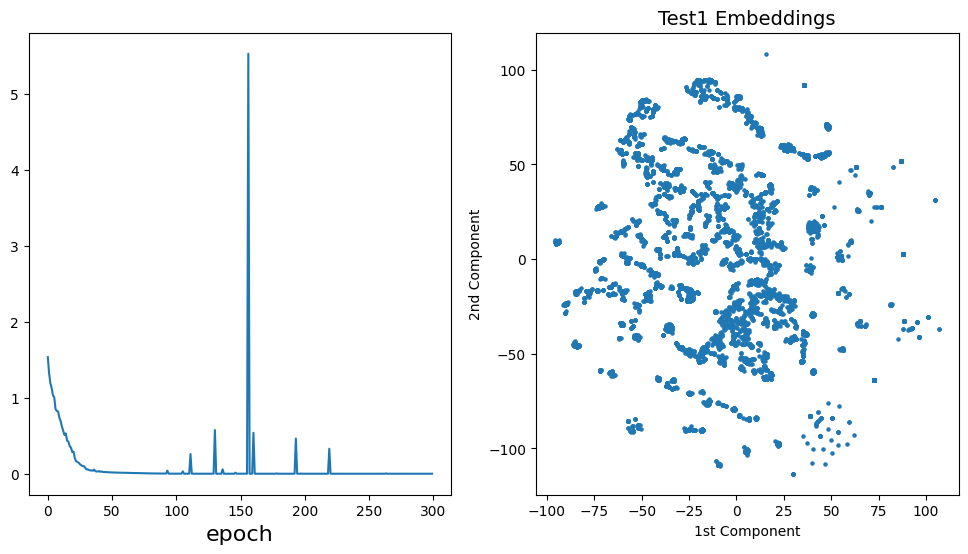

In [177]:
#Plot the loss and accuracy results
fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].plot(np.arange(0,len(loss1list)), loss1list)
ax[0].set_xlabel('epoch',fontsize=16)

ax[1].scatter(test1_visual_embeddings[:,0], test1_visual_embeddings[:,1], s=5)
ax[1].set_xlabel('1st Component',fontsize=10)
ax[1].set_ylabel('2nd Component',fontsize=10)
ax[1].set_title('Test1 Embeddings',fontsize=14)

# Embedding Evaluation (Deprecated)

In [16]:
from copy import deepcopy

#Train models
template_model = DeepGraphInfomax(
    hidden_channels=p, 
    encoder=Encoder(m, p), 
    summary=lambda z, *args, **kwargs: torch.sigmoid(z.mean(dim=0)),
    corruption=corruption
    ).to(device)

rao_merge_DGI = deepcopy(template_model)
rao_merge_optimizer = torch.optim.Adam(rao_merge_DGI.parameters(), lr=0.001)

lieberman_merge_DGI = deepcopy(template_model)
lieberman_merge_optimizer = torch.optim.Adam(lieberman_merge_DGI.parameters(), lr=0.001)

rao_walk_DGI = deepcopy(template_model)
rao_walk_optimizer = torch.optim.Adam(rao_walk_DGI.parameters(), lr=0.001)

lieberman_walk_DGI = deepcopy(template_model)
lieberman_walk_optimizer = torch.optim.Adam(lieberman_walk_DGI.parameters(), lr=0.001)

for epoch in range(1, 101):
    RM_loss = train_DGI(rao_merge_DGI, rao_merge_optimizer, rao_merge_features, rao_edge_list)
    LM_loss = train_DGI(lieberman_merge_DGI, lieberman_merge_optimizer, lieberman_merge_features, lieberman_edge_list)
    
    RW_loss = train_DGI(rao_walk_DGI, rao_walk_optimizer, rao_walk_features, rao_edge_list)
    LW_loss = train_DGI(lieberman_walk_DGI, lieberman_walk_optimizer, lieberman_walk_features, lieberman_edge_list)
    
    print('Epoch',epoch,'RM Loss:',RM_loss.item(),'LM Loss:',LM_loss.item(),'RW Loss:',RW_loss.item(),'LW Loss:',LW_loss.item())

Epoch 1 RM Loss: 1.716158390045166 LM Loss: 1.6183485984802246 RW Loss: 1.3852860927581787 LW Loss: 1.3872709274291992
Epoch 2 RM Loss: 1.431945562362671 LM Loss: 1.4074811935424805 RW Loss: 1.3834432363510132 LW Loss: 1.3873404264450073
Epoch 3 RM Loss: 1.2961170673370361 LM Loss: 1.2846845388412476 RW Loss: 1.3837310075759888 LW Loss: 1.3850674629211426
Epoch 4 RM Loss: 1.1975996494293213 LM Loss: 1.2002347707748413 RW Loss: 1.3834527730941772 LW Loss: 1.3861582279205322
Epoch 5 RM Loss: 1.1773345470428467 LM Loss: 1.1622880697250366 RW Loss: 1.3823132514953613 LW Loss: 1.3876073360443115
Epoch 6 RM Loss: 1.1789331436157227 LM Loss: 1.148587703704834 RW Loss: 1.3832683563232422 LW Loss: 1.3853344917297363
Epoch 7 RM Loss: 1.1897069215774536 LM Loss: 1.1636528968811035 RW Loss: 1.3830313682556152 LW Loss: 1.3872928619384766
Epoch 8 RM Loss: 1.1725090742111206 LM Loss: 1.1342567205429077 RW Loss: 1.381202220916748 LW Loss: 1.3861701488494873
Epoch 9 RM Loss: 1.2027227878570557 LM Loss:

In [17]:
# #Use model to get embeddings
# model = GCN()
# rao_merge_GCN_embeddings = model(rao_merge_features,rao_edge_list).detach().numpy()
# lieberman_merge_GCN_embeddings = model(lieberman_merge_features,lieberman_edge_list).detach().numpy()

# rao_walk_GCN_embeddings = model(rao_walk_features,rao_edge_list).detach().numpy()
# lieberman_walk_GCN_embeddings = model(lieberman_walk_features,lieberman_edge_list).detach().numpy()

rao_merge_DGI.to('cpu')
rao_merge_DGI_embeddings = rao_merge_DGI.encoder(rao_merge_features,rao_edge_list).detach().numpy()
lieberman_merge_DGI.to('cpu')
lieberman_merge_DGI_embeddings = lieberman_merge_DGI.encoder(lieberman_merge_features,lieberman_edge_list).detach().numpy()

rao_walk_DGI.to('cpu')
rao_walk_DGI_embeddings = rao_walk_DGI.encoder(rao_walk_features,rao_edge_list).detach().numpy()
lieberman_walk_DGI.to('cpu')
lieberman_walk_DGI_embeddings = lieberman_walk_DGI.encoder(lieberman_walk_features,lieberman_edge_list).detach().numpy()

We use TSNE to reduce the embeddings into a visualizable dimension

In [18]:
embedding_visualizer = TSNE(n_components=2)

rao_merge_visual_embeddings = embedding_visualizer.fit_transform(rao_merge_DGI_embeddings)
lieberman_merge_visual_embeddings = embedding_visualizer.fit_transform(lieberman_merge_DGI_embeddings)

rao_walk_visual_embeddings = embedding_visualizer.fit_transform(rao_walk_DGI_embeddings)
lieberman_walk_visual_embeddings = embedding_visualizer.fit_transform(lieberman_walk_DGI_embeddings)

Text(0.5, 1.0, 'Lieberman Random Walk Embeddings')

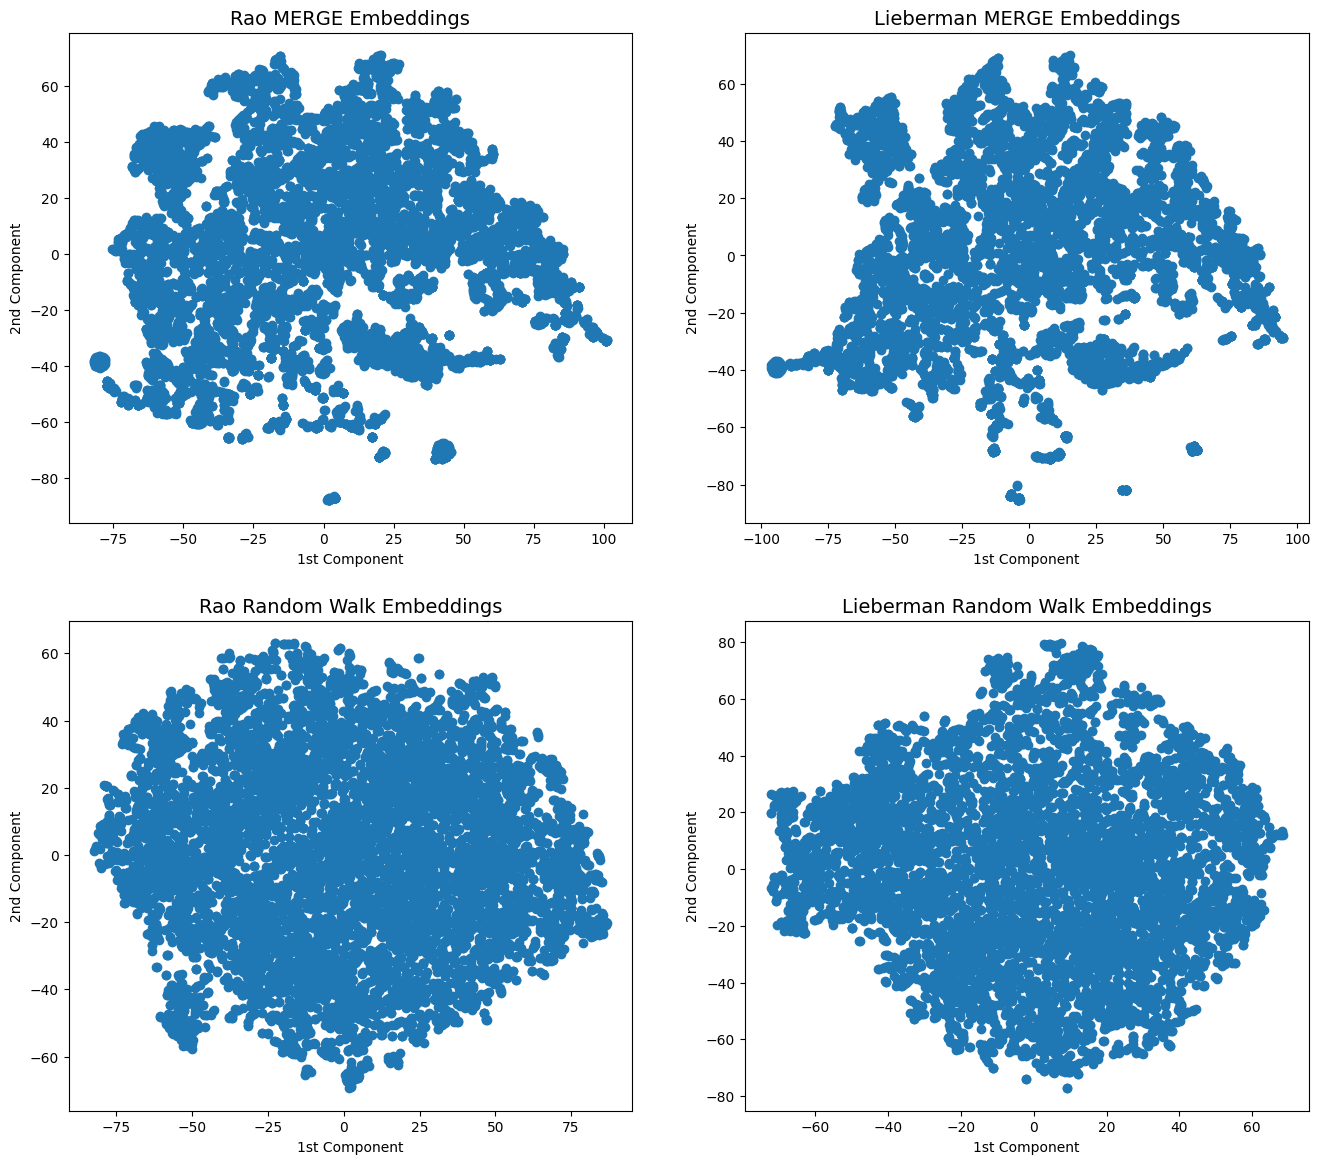

In [19]:
figure, ax = plt.subplots(2,2,figsize=(16,14))

ax[0][0].scatter(rao_merge_visual_embeddings[:,0], rao_merge_visual_embeddings[:,1])
ax[0][0].set_xlabel('1st Component',fontsize=10)
ax[0][0].set_ylabel('2nd Component',fontsize=10)
ax[0][0].set_title('Rao MERGE Embeddings',fontsize=14)
ax[0][1].scatter(lieberman_merge_visual_embeddings[:,0], lieberman_merge_visual_embeddings[:,1])
ax[0][1].set_xlabel('1st Component',fontsize=10)
ax[0][1].set_ylabel('2nd Component',fontsize=10)
ax[0][1].set_title('Lieberman MERGE Embeddings',fontsize=14)

ax[1][0].scatter(rao_walk_visual_embeddings[:,0], rao_walk_visual_embeddings[:,1])
ax[1][0].set_xlabel('1st Component',fontsize=10)
ax[1][0].set_ylabel('2nd Component',fontsize=10)
ax[1][0].set_title('Rao Random Walk Embeddings',fontsize=14)
ax[1][1].scatter(lieberman_walk_visual_embeddings[:,0], lieberman_walk_visual_embeddings[:,1])
ax[1][1].set_xlabel('1st Component',fontsize=10)
ax[1][1].set_ylabel('2nd Component',fontsize=10)
ax[1][1].set_title('Lieberman Random Walk Embeddings',fontsize=14)

In [20]:
from sklearn.metrics import silhouette_score

rao_clustering = KMeans(n_clusters=len(compressed_rao_genes))
lieberman_clustering = KMeans(n_clusters=len(compressed_lieberman_genes))

rao_merge_clusters = rao_clustering.fit_predict(rao_merge_visual_embeddings)
lieberman_merge_clusters = lieberman_clustering.fit_predict(lieberman_merge_visual_embeddings)

rao_merge_silhouette = silhouette_score(rao_merge_visual_embeddings,rao_merge_clusters)
lieberman_merge_silhouette = silhouette_score(lieberman_merge_visual_embeddings,lieberman_merge_clusters)

rao_walk_clusters = rao_clustering.fit_predict(rao_walk_visual_embeddings)
lieberman_walk_clusters = lieberman_clustering.fit_predict(lieberman_walk_visual_embeddings)

rao_walk_silhouette = silhouette_score(rao_walk_visual_embeddings,rao_walk_clusters)
lieberman_walk_silhouette = silhouette_score(lieberman_walk_visual_embeddings,lieberman_walk_clusters)

print(rao_merge_silhouette,lieberman_merge_silhouette,rao_walk_silhouette,lieberman_walk_silhouette)

/fs/johnston/home/cole/Projects/Graph-Compression/.venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/fs/johnston/home/cole/Projects/Graph-Compression/.venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/fs/johnston/home/cole/Projects/Graph-Compression/.venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/fs/johnston/home/cole/Projects/Graph-Compression/.v

0.54338306 0.4968143 0.5058264 0.44005543


In [ ]:
def get_gene_clusters(protein_list,protein_clusters,gene_list):
    protein_labels = {}
    for i,protein in enumerate(protein_list):
        protein_labels[protein] = protein_clusters[i]
    
    gene_labels = {}
    for cluster in gene_list:
        genes = cluster.split('+')
        temp_labels = []
        for gene in genes:
            temp_labels.append(protein_labels[gene])
        cluster_label = mode(temp_labels)[0]
        for gene in genes:
            gene_labels[gene] = cluster_label
    return gene_labels

# MERGE Compression (Deprecated)

## Guiding List

In [16]:
#Reduce size of protein list based on degree threshold η and store features of reduced proteins
def reduce_embeddings(embeddings,D,protein_list,eta):
    reduced_protein_list = []
    reduced_features = []
    for i in range(len(protein_list)):
        if D[i,i] >= eta:
            reduced_protein_list.append(protein_list[i])
            reduced_features.append(embeddings[i].cpu().detach().numpy())
    return reduced_protein_list, reduced_features

reduced_lieberman_proteins, reduced_lieberman_embeddings = reduce_embeddings(lieberman_embeddings,lieberman_D,lieberman_proteins,eta)
reduced_rao_proteins, reduced_rao_embeddings = reduce_embeddings(rao_embeddings,rao_D,rao_proteins,eta)
print(len(reduced_lieberman_proteins),len(reduced_rao_proteins))

1401 1826


In [17]:
#Initialize list of norms and sort protein list based on norms
def sort_proteins(reduced_features,reduced_protein_list):
    norms = []
    for i in range(len(reduced_features)):
        norms.append(np.linalg.norm(reduced_features[i]))

    sorted_protein_list = [x for _,x in sorted(zip(norms,reduced_protein_list),reverse=True)]
    return sorted_protein_list

sorted_lieberman_proteins = sort_proteins(reduced_lieberman_embeddings,reduced_lieberman_proteins)
sorted_rao_proteins = sort_proteins(reduced_rao_embeddings,reduced_rao_proteins)
print(len(sorted_lieberman_proteins),len(sorted_rao_proteins))

1401 1826


## Compression

In [18]:
#Get neighbors using adjacency matrix
def get_Neighbors(protein_idx,A):
    neighbors = []
    for i in range(len(A)):
        if A[protein_idx,i] == 1:
            neighbors.append(i)
    return neighbors

In [14]:
def compress(protein_list,sorted_protein_list,edge_list,A,D,phi,max_degree):
    #Initialize compress_rate and make deep copies of protein list
    compress_rate = 0
    compressed_A = A.clone()
    compressed_D = D.clone()
    compressed_edge_list = edge_list.clone()
    compressed_protein_list = protein_list.copy()
    guided_list = sorted_protein_list.copy()

    #Compress loop
    while compress_rate < phi:
        
        #Iterate through guided list:
        for protein in guided_list:
            
            #Get minimum degree of neighbors
            protein_idx = compressed_protein_list.index(protein)
            neighbors = get_Neighbors(protein_idx,compressed_A)
            min_degree = max_degree
            for neighbor_idx in neighbors:
                neighbor_degree = compressed_D[neighbor_idx,neighbor_idx].item()
                min_degree = min(min_degree,neighbor_degree)
            
            #Make list of nodes for compression based on minimum degree
            compress_list = []
            for neighbor_idx in neighbors:
                neighbor_degree = compressed_D[neighbor_idx,neighbor_idx].item()
                if neighbor_degree == min_degree:
                    compress_list.append(neighbor_idx)
            compress_list.append(protein_idx)
            
            #Compress nodes in compress list
            if len(compress_list) > 1:
                supernode = '+'.join([compressed_protein_list[i] for i in compress_list])
                
                supernode_neighbors = set()
                
                #Store supernode neighbors
                for subnode_idx in compress_list:
                    supernode_neighbors = supernode_neighbors | set(get_Neighbors(subnode_idx,compressed_A))
                
                ##Update Adjacency Matrix
                
                #Add Supernode and connections
                compressed_A = torch.cat([compressed_A,torch.zeros(1,len(compressed_A))])
                compressed_A = torch.cat([compressed_A,torch.zeros(len(compressed_A),1)],dim=1)
                
                for neighbor in supernode_neighbors:
                    compressed_A[-1,neighbor] = 1
                    compressed_A[neighbor,-1] = 1
                    
                #Remove subnodes
                for subnode_idx in sorted(compress_list,reverse=True):
                    compressed_A = torch.cat([compressed_A[:subnode_idx],compressed_A[subnode_idx+1:]])
                    compressed_A = torch.cat([compressed_A[:,:subnode_idx],compressed_A[:,subnode_idx+1:]],dim=1)
                
                ##Update Degree Matrix
                compressed_D = construct_degree_matrix(compressed_A)
                
                ##Update Guided List
                for subnode_idx in compress_list:
                    if compressed_protein_list[subnode_idx] in guided_list:
                        guided_list.remove(compressed_protein_list[subnode_idx])
                guided_list.append(supernode)
                
                ##Update Protein List
                compressed_protein_list.append(supernode)
                for subnode_idx in sorted(compress_list,reverse=True):
                    compressed_protein_list.remove(compressed_protein_list[subnode_idx])
                

            compress_rate = 1 - len(compressed_protein_list)/len(protein_list)
            print(compress_rate)
            if compress_rate >= phi:
                return compressed_protein_list,compressed_A,compressed_D

compressed_lieberman_proteins,compressed_lieberman_A,compressed_lieberman_D, = compress(lieberman_proteins,sorted_lieberman_proteins,lieberman_edge_list,lieberman_A,lieberman_D,lieberman_phi,lieberman_max)
compressed_rao_proteins,compressed_rao_A,compressed_rao_D, = compress(rao_proteins,sorted_rao_proteins,rao_edge_list,rao_A,rao_D,rao_phi,rao_max)

0.0018721198156681496
0.0036002304147465525
0.003888248847926268
0.005328341013824844
0.007056451612903247
0.007344470046082963
0.008496543778801824
0.00936059907834097
0.010224654377880227
0.010800691244239657
0.011520737327188946
0.013248847926267238
0.01382488479262678
0.01497695852534564
0.017281105990783363
0.01742511520737322
0.023329493087557607
0.02376152073732718
0.025201612903225756
0.025345622119815614
0.0267857142857143
0.027217741935483875
0.027793778801843305
0.02808179723502302
0.028369815668202736
0.031538018433179715
0.03254608294930872
0.03312211981566815
0.03326612903225812
0.03427419354838712
0.03456221198156684
0.034706221198156695
0.035282258064516125
0.03542626728110598
0.0367223502304147
0.037154377880184386
0.037298387096774244
0.038450460829493105
0.03859447004608296
0.03931451612903225
0.039746543778801824
0.04003456221198154
0.04046658986175111
0.040898617511520685
0.04118663594470051
0.04133064516129037
0.041618663594470084
0.04176267281105994
0.04190668202

In [18]:
#Save compressed protein list
np.savetxt(working_dict + "/Data/HI-union_compressedLieberman.csv",compressed_lieberman_proteins,fmt='%s')
np.savetxt(working_dict + "/Data/HI-union_compressedRao.csv",compressed_rao_proteins,fmt='%s')

# Evaluation

In [54]:
#Assign protein and gene labels for clustering
def assign_protein_labels(protein_list):
    labels = {}
    for label,cluster in enumerate(protein_list):
        proteins = cluster.split('+')
        for protein in proteins:
            labels[protein] = label
    return labels

rao_protein_labels = assign_protein_labels(compressed_rao_proteins)
lieberman_protein_labels = assign_protein_labels(compressed_lieberman_proteins)

def assign_gene_labels(gene_list,protein_labels):
    labels = {}
    for cluster in gene_list:
        genes = cluster.split('+')
        temp_labels = []
        for gene in genes:
            temp_labels.append(protein_labels[gene])
        cluster_label = mode(temp_labels)[0]
        for gene in genes:
            labels[gene] = cluster_label
    return labels

rao_gene_labels = assign_gene_labels(compressed_rao_genes,rao_protein_labels)
lieberman_gene_labels = assign_gene_labels(compressed_lieberman_genes,lieberman_protein_labels)

In [55]:
#Create arrays for ARI calculation
def produce_array(data,labels):
    array = []
    for point in data:
        array.append(labels[point])
    return np.array(array)

rao_PPI = produce_array(rao_genes,rao_gene_labels)
rao_DNA = produce_array(rao_genes,rao_protein_labels)

lieberman_PPI = produce_array(lieberman_genes,lieberman_gene_labels)
lieberman_DNA = produce_array(lieberman_genes,lieberman_protein_labels)

In [58]:
#Calculate ARI
from sklearn.metrics import adjusted_rand_score
print(adjusted_rand_score(rao_PPI,rao_DNA))
print(adjusted_rand_score(lieberman_PPI,lieberman_DNA))

0.05065541063513176
0.021388982378138598
